In [10]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString

## Case Study: Analyzing the Complexity of New York's Road Network

The goal of this project is to profile the structural complexity of different urban road networks.

The goal is to describe the motifs of road networks with high complexity. Specifically, what makes one road network quantifiably more complex than another?

In order to answer this question, we first have to have some data. And not just any data, but and ultra-clean network-structured dataset that encodes road information. This graph encoding will need to support compression, MDL estimation, and eventually display for my website.

In [11]:
def get_city_center(G):
    # Option A: centroid of node coordinates
    xs = [data["x"] for _, data in G.nodes(data=True)]
    ys = [data["y"] for _, data in G.nodes(data=True)]
    return np.mean(xs), np.mean(ys)

def make_radii(max_km=10, step_km=0.5):
    # radii in meters
    return np.arange(step_km * 1000, max_km * 1000 + 1, step_km * 1000)

def mdl_er_graph(G_sub):
    n = G_sub.number_of_nodes()
    m = G_sub.number_of_edges()
    if n < 2:
        return 0.0

    N_pairs = n * (n - 1) / 2
    if N_pairs == 0:
        return 0.0

    p = m / N_pairs if N_pairs > 0 else 0.0

    # avoid log(0)
    eps = 1e-10
    p = min(max(p, eps), 1 - eps)

    logL = m * math.log(p) + (N_pairs - m) * math.log(1 - p)
    # convert to bits
    return -logL / math.log(2)

def compute_radius_subgraphs(G, center_lon, center_lat, radii_m):
    # Convert nodes to projected CRS so distances are in meters
    nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)
    
    # Project to a local metric CRS
    nodes_proj = nodes_gdf.to_crs(epsg=3857)  # Web Mercator is fine for experiment
    center_point = gpd.GeoSeries([Point(center_lon, center_lat)], crs="EPSG:4326").to_crs(nodes_proj.crs)[0]
    
    # Precompute distances from center (in meters)
    distances = nodes_proj.geometry.distance(center_point)  # pandas Series indexed by node id

    radius_results = []

    for r in radii_m:
        # nodes within radius r
        nodes_in = distances[distances <= r].index
        if len(nodes_in) < 2:
            continue  # nothing interesting to encode yet

        G_r = G.subgraph(nodes_in).copy()
        radius_results.append((r, G_r))

    return radius_results

def mdl_stats(G_sub):
    n = G_sub.number_of_nodes()
    m = G_sub.number_of_edges()
    L = mdl_er_graph(G_sub)
    return {
        "n_nodes": n,
        "n_edges": m,
        "mdl_bits": L,
        "mdl_per_edge": L / m if m > 0 else float("nan"),
        "mdl_per_node": L / n if n > 0 else float("nan"),
    }



In [12]:
# Define place name or coordinates
places = [
    "Manhattan, New York, USA",
    "San Francisco, California, USA",
    "Detroit, Michigan, USA",
    "Chicago, Illinois, USA",
    "Los Angeles, California, USA",
    "Washington, D.C., USA",
    "Seattle, Washington, USA",
    "Miami, Florida, USA",
]

map_data = {}
for place in places:
    # Extract network within bounding box or boundary
    G = ox.graph_from_place(place, network_type='drive')
    map_data[place] = G


The first thing I wanna do is take a look at the data we're seeing here. We have Manhattan, SF, Detroit, Chicago, LA, DC, Seattle, and Miami. Each of these geographies has their quirks (Detroit's administrative boundaries include two intentionally segregated cities, Seattle and SF are hopelessly strewn across hillsides, and Chicago has that damn grid).

I'd like to see the amount of information encoded before and after our cleaning process. The difference indicates the amount of extraneous information that was stripped during cleaning. This information would ideally be non-topological so as to keep the important road data.

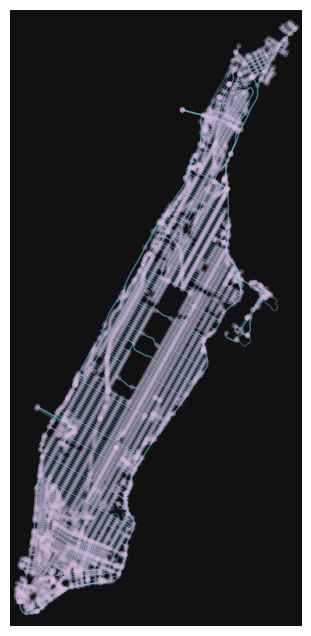

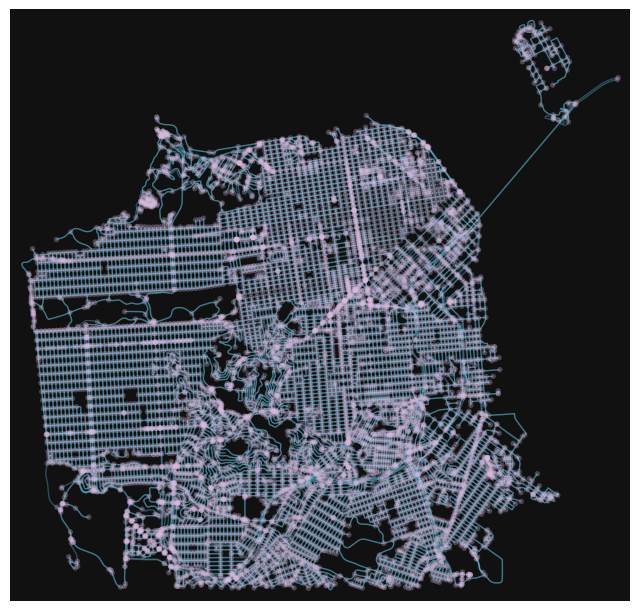

In [ ]:
cleaned_map_data = {}

for place in map_data:
    G = map_data[place]
    ox.plot_graph(G,
        bgcolor="#111111",
        node_color="#DBBADD",
        node_size=15,
        node_alpha=0.3,
        node_edgecolor="none",
        node_zorder=1,
        edge_color="#69DDFF",
        edge_alpha=0.3
    )
    # save figure
    plt.savefig(f"{place}_map.png", dpi=600)
    plt.close()
    # clean the data
    try: 
        G_simplified = ox.simplification.simplify_graph(G)
        G_proj = ox.project_graph(G)
        G_std = ox.convert.graph_to_gdfs(G_proj, nodes=True, edges=True)
        cleaned_map_data[place] = G_std
    except:
        G_proj = ox.project_graph(G)
        G_std = ox.convert.graph_to_gdfs(G_proj, nodes=True, edges=True)
        cleaned_map_data[place] = G_std
        
    # generate canonical representations
    filename = f"{place}"
    nx.write_adjlist(G, str(filename) + ".adjlist")
    g6 = nx.to_graph6_bytes(nx.Graph(G), header=False)
    with open(str(filename) + ".g6", "wb") as f:
        f.write(g6)
    nx.write_edgelist(G, str(filename) + ".edgelist", data=False)

    all_radius_rows = []

    for place, G in map_data.items():
        center_lon, center_lat = get_city_center(G)
        radii_m = make_radii(max_km=10, step_km=0.5)

        radius_subgraphs = compute_radius_subgraphs(G, center_lon, center_lat, radii_m)

        for r, G_r in radius_subgraphs:
            stats = mdl_stats(G_r)
            stats.update({
                "place": place,
                "radius_m": r,
            })
            all_radius_rows.append(stats)

    # save experiment results
    mdl_radius_df = pd.DataFrame(all_radius_rows)
    mdl_radius_df.to_csv("mdl_radius_results.csv", index=False)

def plot_mdl_radius(mdl_df, place):
    df = mdl_df[mdl_df["place"] == place].sort_values("radius_m")
    plt.figure()
    plt.plot(df["radius_m"] / 1000, df["mdl_per_edge"], marker="o")
    plt.xlabel("Radius (km)")
    plt.ylabel("MDL per edge (bits)")
    plt.title(f"MDL radius curve – {place}")
    plt.grid(True)
    plt.show()

In [ ]:
for place, G in map_data.items():
    center_lon, center_lat = get_city_center(G)
    radii_m = make_radii(max_km=10, step_km=0.5)

In [ ]:
def plot_mdl_radius(mdl_df, place):
    df = mdl_df[mdl_df["place"] == place].sort_values("radius_m")
    plt.figure()
    plt.plot(df["radius_m"] / 1000, df["mdl_per_edge"], marker="o")
    plt.xlabel("Radius (km)")
    plt.ylabel("MDL per edge (bits)")
    plt.title(f"MDL radius curve – {place}")
    plt.grid(True)
    plt.show()


In [ ]:
all_radius_rows = []
for place, G in map_data.items():
    center_lon, center_lat = get_city_center(G)
    radii_m = make_radii(max_km=10, step_km=0.5)

    radius_subgraphs = compute_radius_subgraphs(G, center_lon, center_lat, radii_m)

    for r, G_r in radius_subgraphs:
        stats = mdl_stats(G_r)
        stats.update({
            "place": place,
            "radius_m": r,
        })
        all_radius_rows.append(stats)

# save experiment results
mdl_radius_df = pd.DataFrame(all_radius_rows)
mdl_radius_df.to_csv("mdl_radius_results.csv", index=False)


In [ ]:
import matplotlib.pyplot as plt

def plot_mdl_radius(mdl_df, place):
    df = mdl_df[mdl_df["place"] == place].sort_values("radius_m")
    plt.figure()
    plt.plot(df["radius_m"] / 1000, df["mdl_per_edge"], marker="o")
    plt.xlabel("Radius (km)")
    plt.ylabel("MDL per edge (bits)")
    plt.title(f"MDL radius curve – {place}")
    plt.grid(True)
    plt.show()


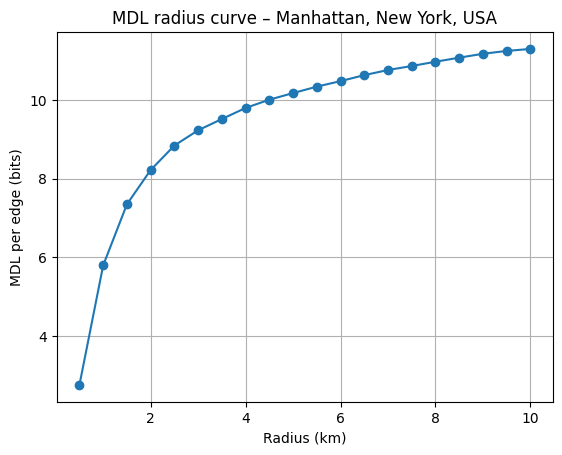

In [ ]:
for place, G in map_data.items():
    plot_mdl_radius(mdl_radius_df, place)